Dataset ImageFolder
    Number of datapoints: 1011
    Root location: C:\Users\naras\.spyder-py3\document
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 1011
    Root location: C:\Users\naras\.spyder-py3\document
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


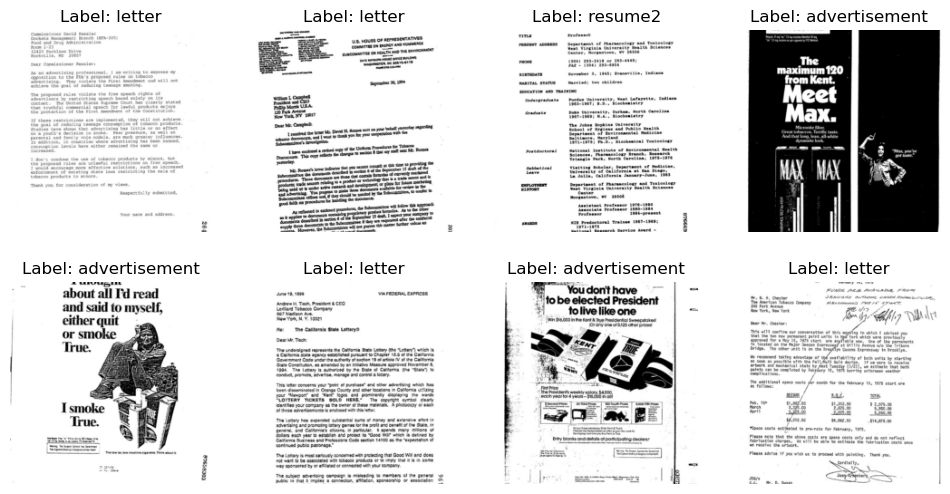

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=

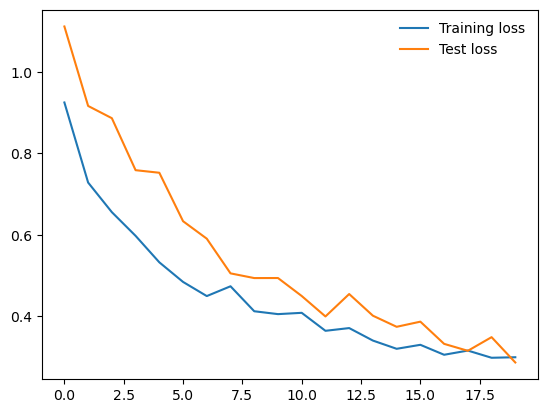

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Load the dataset
dat_dir = r'C:\Users\naras\.spyder-py3\document'
trainset = datasets.ImageFolder(dat_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testset = datasets.ImageFolder(dat_dir, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

print(testloader.dataset)
print(trainloader.dataset)

# Visualize some images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Use next() directly

fig, axes = plt.subplots(figsize=(12, 6), nrows=2, ncols=4)
for ii, (image, label) in enumerate(zip(images[:8], labels[:8])):
    ax = axes[ii // 4, ii % 4]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f'Label: {trainset.classes[label]}')
    ax.axis('off')
plt.show()

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv2_drop = nn.Dropout2d(p=0.5)
        
        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224))
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def convs(self, x):
        x = F.relu(self.bn1(F.max_pool2d(self.conv1(x), 2)))
        x = F.relu(self.bn2(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)))
        x = F.relu(self.bn3(F.max_pool2d(self.conv3(x), 2)))
        x = F.relu(self.bn4(F.max_pool2d(self.conv4(x), 2)))
        x = F.relu(self.bn5(F.max_pool2d(self.conv5(x), 2)))
        if self._to_linear is None:
            self._to_linear = x.view(-1).shape[0]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.NLLLoss()

epochs = 20
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    net.train() 
    for images, labels in trainloader:
        # Clear the gradients
        optimizer.zero_grad() 
        # Forward pass, get our logits
        log_ps = net(images) 
        # Calculate the loss with the logits and the labels
        loss = criterion(log_ps, labels)
        # Calculate the gradients
        loss.backward() 
        # Update the weights
        optimizer.step() 
         
        running_loss += loss.item() 
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        net.eval()
        with torch.no_grad(): 
            for images, labels in testloader:
                log_ps = net(images)
                test_loss += criterion(log_ps, labels).item()
                
                ps = torch.exp(log_ps) 
                top_p, top_class = ps.topk(1, dim=1) 
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        # print training/test statistics
        print(f"Epoch: {e+1}/{epochs}.. "
              f"Training Loss: {running_loss/len(trainloader):.3f}.. "
              f"Test Loss: {test_loss/len(testloader):.3f}.. "
              f"Test Accuracy: {accuracy/len(testloader):.3f}")

# Plotting training and test losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)
plt.show()